Sources: https://www.kaggle.com/code/dangelov/covid-19-topic-modeling-and-search-with-top2vec


## Installing & Importing Packages

In [1]:
!pip install top2vec


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install top2vec[sentence_encoders]

  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
INFO: pip is looking at multiple versions of top2vec[sentence-encoders] to determine which version is compatible with other requirements. This could take a while.
  Using cached top2vec-1.0.33-py3-none-any.whl (27 kB)
  Using cached top2vec-1.0.32-py3-none-any.whl (27 kB)
  Using cached top2vec-1.0.31-py3-none-any.whl (27 kB)
  Using cached top2vec-1.0.30-py3-none-any.whl (26 kB)
  Using cached top2vec-1.0.29-py3-none-any.whl (26 kB)
  Using cached top2vec-1.0.28-py3-none-any.whl (25 kB)
  Using cached top2vec-1.0.27-py3-none-any.whl (25 kB)
INFO: pip is looking at multiple versions of top2vec[sentence-encoders] to determine which version is compatible with other requirements. This could take a while.
  Using cached top2vec-1.0.26-py3-none-any.whl (23 kB)
  Using cached gensim-3.8.3.tar.gz (23.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached top2ve

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [93 lines of output]
      Running from numpy source directory.
      setup.py:470: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
        run_build = parse_setuppy_commands()
      Cythonizing sources
      Processing numpy/random\_bounded_integers.pxd.in
      Processing numpy/random\bit_generator.pyx
      Processing numpy/random\mtrand.pyx
      Processing numpy/random\_bounded_integers.pyx.in
      Processing numpy/random\_common.pyx
      performance hint: _common.pyx:275:19: Exception check after calling 'random_func' will always require the GIL to be acquired. Declare 'random_func' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
      performance hint: _common.pyx:299:19: Exception check after calling 'random_func' will always

In [3]:
!pip install tensorflow tensorflow_hub tensorflow_text

  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)


ERROR: Could not find a version that satisfies the requirement tensorflow_text (from versions: none)
ERROR: No matching distribution found for tensorflow_text

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install torch sentence_transformers


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install groq


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from top2vec import Top2Vec
import math

c:\Users\14015\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from groq import Groq
import dotenv
import os

dotenv.load_dotenv()

True

#### API_KEY

In [4]:
GROQ_API_KEY=os.getenv("GROQ_API_KEY")

## Function for refining topics using llama3 model

In [5]:
system_message = """
Generate a concise and coherent phrase that summarizes topics based on provided keywords
and associated review ratings. The keywords are ordered by relevance from the most to the least.


Ensure that each phrase accurately reflects the sentiment implied by the rating and highlights key aspects of the topic.
For example, a rating of 1 should convey dissatisfaction or issues, while a rating of 5 should express satisfaction or positive feedback.
Omit pronouns and conjunctions to keep the phrase succinct.


For reviews with low ratings (1-2) or with negative keywords, focus on problematic aspects such as defects, damages, or poor quality and
be as detailed as possible.


Output only the phrase without additional commentary.


Example:


Input: "leak box, return, item, bottle leak, arrive damage, box, arrive, damage leak, damage, leak" Rating: 1
Output: "Leaking or damaged items and boxes upon delivery"
"""
client = Groq(api_key = GROQ_API_KEY)
def process_input(top_words, rating):
   user_message = f'Input: "{top_words}" rating: {rating}'
   response = client.chat.completions.create(
       messages=[
           {
               "role": "system",
               "content": system_message
           },
           {
               "role": "user",
               "content": user_message
           }
       ],
       model="llama3-8b-8192",
   )
   generated_phrase = response.choices[0].message.content
   return generated_phrase

## Functions to dynamically get the number of topics based on the number of reviews in each star rating

In [6]:
def calculate_num_topics_star_rating(total_topics, star_rating, min_topics=1):
    # logarithmic weighting (smooth it out)
    weight = math.log(6 - star_rating + 1)  # Adding 1 to avoid log(0)


    # normalize weight to ensure sum of the topics is not greater than total_topics
    total_weight = sum(math.log(6 - r + 1) for r in range(1, 6))
    normalized_weight = weight / total_weight


    # number of topics for the group based on normalized weight
    num_topics = max(min_topics, math.ceil(normalized_weight * total_topics))


    return num_topics

In [7]:
def get_number_topics(num_reviews):
    if num_reviews > 50000:
        return 20
    if num_reviews > 25000:
        return 15
    if num_reviews > 10000:
        return 10
    if num_reviews > 5000:
        return 8
    if num_reviews > 1000:
        return 6
    if num_reviews > 500:
        return 5
    if num_reviews > 100:
        return 4
    if num_reviews > 50:
        return 3
    if num_reviews > 10:
        return 2
    return 1

## Load the data and segment based on star_rating

In [9]:
df = pd.read_csv("data/processed_reviews.csv")
df.head()

,brand,product_title,proxy_date,retailer,category,subcategory,review_text,star_rating,topic,brand_type
0,Clorox,Clorox Wring Clean Cotton Mop,2024-07-08,Target,CLEANING,FLOOR CLEANERS,the mop be cheap the wringing attachment doesn...,1.0,Product review: Click n Clean multi-surface sp...,Clorox
1,Rapid,"32 oz. Rapid Clean Remediation, Trigger Spray ...",2024-07-08,Home Depot,CLEANING,BATHROOM CLEANERS MILDEW CLEANERS,this product be recommend for a front load was...,1.0,Mold removal and prevention products,Competitor
2,Mrs. Meyer's Clean Day,Mrs Meyers Clean Day Cleaner Plastic Bottle Mu...,2024-07-08,Target,CLEANING,SPRAY CLEANERS ALL PURPOSE CLEANERS,smell so good definitely my favorite scent,5.0,Fall scents and their popularity,Competitor
3,Pourri,Poo Pourri Plastic Spray Bottle Toilet Oil Fre...,2024-07-08,Target,CLEANING,ODOR CONTROLLING AIR FRESHENERS,i keep multiple bottle in the bathroom and car...,5.0,Household cleaning and sanitization tips,Competitor
4,Twist & Shout,Twist & Shout Spin Mop & Bucket System with 1 ...,2024-07-01,Costco,CLEANING,FLOOR CLEANERS,i recently just get this mop love how easy it ...,5.0,Product review: Click n Clean multi-surface sp...,Competitor


In [10]:
clorox_df = df[df['subcategory'] == 'BODY CARE BODY LOTION'] # ensures we are only looking at one subcategory
clorox_df.head()

,brand,product_title,proxy_date,retailer,category,subcategory,review_text,star_rating,topic,brand_type
210565,Palmer's,Palmer's Cocoa Butter Formula Daily Skin Thera...,2024-07-01,CVS,PERSONAL CARE,BODY CARE BODY LOTION,i have use this lotion for year and love it ve...,5.0,Moisturizer preference and usage habits,Competitor
210757,EOS,eos Shea Better Moisture Body Lotion - Vanilla...,2024-07-01,Target,PERSONAL CARE,BODY CARE BODY LOTION,ive be look for a new body lotion from a compa...,3.0,Positive reviews for a makeup remover (undeter...,Competitor
210829,Eucerin,Eucerin Intensive Repair Very Dry Skin Lotion ...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,this lotion be a must have if you have dry ski...,5.0,Positive reviews for a makeup remover (undeter...,Competitor
210925,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,no retinol list on ingredient list,1.0,Positive reviews for a makeup remover (undeter...,Competitor
211032,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,i love this lotion lovely scent it have bright...,5.0,Positive reviews for a makeup remover (undeter...,Competitor


In [11]:
clorox_df['topic'].unique()

array(['Moisturizer preference and usage habits',
       'Positive reviews for a makeup remover (undetermined topic)',
       'Personal experiences with non-greasy moisturizers',
       'Scented body scrubs and their effects',
       'Positive scent experiences with Jerkins lotion',
       'Olay product reviews and affordability',
       'Fast and affordable shipping options',
       'Positive customer feedback and satisfaction',
       'Convenience and versatility of portable products',
       'Scent and longevity of personal care products',
       'Similar scents to Bath and Body Works\' "Vanilla Bean Noel" lotion',
       'Skincare product reviews and customer complaints',
       'Fragrances and scents', 'Review of Neutrogena products',
       'Skincare product reviews',
       'Favorite beauty products (specifically moisturizers)',
       'Skincare products and their effects on skin',
       'Skin care for arms and legs', 'Hydrating face cream reviews',
       'Personal reviews of 

In [12]:
clorox_df['topic'].nunique()

677

In [13]:
clorox_df.shape # ~ 20821 reviews

(20281, 10)

In [14]:
num_topics_to_generate = get_number_topics(clorox_df.shape[0])

In [15]:
clorox_df_1 = clorox_df[clorox_df['star_rating'] == 1]
print(clorox_df_1.shape)
clorox_df_2 = clorox_df[clorox_df['star_rating'] == 2]
print(clorox_df_2.shape)
clorox_df_3 = clorox_df[clorox_df['star_rating'] == 3]
print(clorox_df_3.shape)
clorox_df_4 = clorox_df[clorox_df['star_rating'] == 4]
print(clorox_df_4.shape)
clorox_df_5 = clorox_df[clorox_df['star_rating'] == 5]
print(clorox_df_5.shape)

(1525, 10)
(666, 10)
(1059, 10)
(2597, 10)
(14434, 10)


## Training and Saving Top2Vec Models

In [17]:
top2vec1 = Top2Vec(documents=list(clorox_df_1['review_text']), speed='deep-learn', embedding_model='doc2vec', workers=20, ngram_vocab=True)
top2vec2 = Top2Vec(documents=list(clorox_df_2['review_text']), speed='deep-learn', embedding_model='doc2vec', workers=20, ngram_vocab=True)
top2vec3 = Top2Vec(documents=list(clorox_df_3['review_text']), speed='deep-learn', embedding_model='doc2vec', workers=20, ngram_vocab=True)
top2vec4 = Top2Vec(documents=list(clorox_df_4['review_text']), speed='deep-learn', embedding_model='doc2vec', workers=20, ngram_vocab=True)
top2vec5 = Top2Vec(documents=list(clorox_df_5['review_text']), speed='deep-learn', embedding_model='doc2vec', workers=20, ngram_vocab=True)


2024-10-12 12:06:29,869 - top2vec - INFO - Pre-processing documents for training
2024-10-12 12:06:30,039 - top2vec - INFO - Creating joint document/word embedding
2024-10-12 12:09:35,768 - top2vec - INFO - Creating lower dimension embedding of documents
2024-10-12 12:10:11,883 - top2vec - INFO - Finding dense areas of documents
2024-10-12 12:10:12,006 - top2vec - INFO - Finding topics
2024-10-12 12:10:12,031 - top2vec - INFO - Pre-processing documents for training
2024-10-12 12:10:12,180 - top2vec - INFO - Creating joint document/word embedding
2024-10-12 12:10:58,695 - top2vec - INFO - Creating lower dimension embedding of documents
2024-10-12 12:11:03,736 - top2vec - INFO - Finding dense areas of documents
2024-10-12 12:11:03,760 - top2vec - INFO - Finding topics
2024-10-12 12:11:03,771 - top2vec - INFO - Pre-processing documents for training
2024-10-12 12:11:03,859 - top2vec - INFO - Creating joint document/word embedding
2024-10-12 12:12:11,627 - top2vec - INFO - Creating lower dim

In [18]:
top2vec1.save("top2vec_saved_models/top2vec_1_star")
top2vec2.save("top2vec_saved_models/top2vec_2_star")
top2vec3.save("top2vec_saved_models/top2vec_3_star")
top2vec4.save("top2vec_saved_models/top2vec_4_star")
top2vec5.save("top2vec_saved_models/top2vec_5_star")

## To avoid retraining Top2Vec models, load the models HERE 

In [16]:
clorox_dataframes = [clorox_df_1, clorox_df_2, clorox_df_3, clorox_df_4, clorox_df_5]

In [17]:
top2vec1 = Top2Vec.load("top2vec_saved_models/top2vec_1_star")
top2vec2 = Top2Vec.load("top2vec_saved_models/top2vec_2_star")
top2vec3 = Top2Vec.load("top2vec_saved_models/top2vec_3_star")
top2vec4 = Top2Vec.load("top2vec_saved_models/top2vec_4_star")
top2vec5 = Top2Vec.load("top2vec_saved_models/top2vec_5_star")
top2vec_models = [top2vec1, top2vec2, top2vec3, top2vec4, top2vec5]

In [18]:
num_topics_1 = top2vec1.get_num_topics()
num_topics_2 = top2vec2.get_num_topics()
num_topics_3 = top2vec3.get_num_topics()
num_topics_4 = top2vec4.get_num_topics()
num_topics_5 = top2vec5.get_num_topics()
num_topics_generated = [num_topics_1, num_topics_2, num_topics_3, num_topics_4, num_topics_5]

In [19]:
print("Number of topics for 1 star reviews: ", num_topics_1)
print("Number of topics for 2 star reviews: ", num_topics_2)
print("Number of topics for 3 star reviews: ", num_topics_3)
print("Number of topics for 4 star reviews: ", num_topics_4)
print("Number of topics for 5 star reviews: ", num_topics_5)

Number of topics for 1 star reviews:  14
Number of topics for 2 star reviews:  7
Number of topics for 3 star reviews:  4
Number of topics for 4 star reviews:  2
Number of topics for 5 star reviews:  169


In [20]:
total_num_topics_desired = get_number_topics(clorox_df.shape[0])

desired_num_topics_1 = calculate_num_topics_star_rating(total_num_topics_desired, 1)
desired_num_topics_2 = calculate_num_topics_star_rating(total_num_topics_desired, 2)
desired_num_topics_3 = calculate_num_topics_star_rating(total_num_topics_desired, 3)
desired_num_topics_4 = calculate_num_topics_star_rating(total_num_topics_desired, 4)
desired_num_topics_5 = calculate_num_topics_star_rating(total_num_topics_desired, 5)

desired_num_topics = [desired_num_topics_1, desired_num_topics_2, desired_num_topics_3, desired_num_topics_4, desired_num_topics_5]

In [21]:
print("Desired number of topics for 1 star reviews: ", desired_num_topics_1)
print("Desired number of topics for 2 star reviews: ", desired_num_topics_2)
print("Desired number of topics for 3 star reviews: ", desired_num_topics_3)
print("Desired number of topics for 4 star reviews: ", desired_num_topics_4)
print("Desired number of topics for 5 star reviews: ", desired_num_topics_5)
print("Total desired number of topics: ", total_num_topics_desired)
print("Total desired number of topics (actually) : ", sum(desired_num_topics))

Desired number of topics for 1 star reviews:  3
Desired number of topics for 2 star reviews:  3
Desired number of topics for 3 star reviews:  3
Desired number of topics for 4 star reviews:  2
Desired number of topics for 5 star reviews:  2
Total desired number of topics:  10
Total desired number of topics (actually) :  13


## Do topic reduction, if necessary

In [22]:
topic_reduction = [False]*len(num_topics_generated)
for i in range(len(num_topics_generated)):
    if num_topics_generated[i] > desired_num_topics[i]: # the number of topics generated is greater than the number of desired topics
        # perform hierarchial topic reduction
        topic_reduction[i] = True
        top2vec_models[i].hierarchical_topic_reduction(desired_num_topics[i])

In [23]:
print("Number of topics for top2vec1", top2vec1.get_num_topics(reduced=True))
print("Number of topics for top2vec2", top2vec2.get_num_topics(reduced=True))
print("Number of topics for top2vec3", top2vec3.get_num_topics(reduced=True))
print("Number of topics for top2vec4", top2vec4.get_num_topics())
print("Number of topics for top2vec5", top2vec5.get_num_topics(reduced=True))


Number of topics for top2vec1 3
Number of topics for top2vec2 3
Number of topics for top2vec3 3
Number of topics for top2vec4 2
Number of topics for top2vec5 2


## Get the Topics and Refine them through the LLM

In [24]:
refined_topics = {}
for i in range(len(top2vec_models)):
    topic_words, word_scores, topic_nums = top2vec_models[i].get_topics(reduced=topic_reduction[i])
    for top_50_topic_words in topic_words:
        if refined_topics.get(i+1) is None:
            refined_topics[i+1] = []
        refined_topics[i+1].append(process_input(top_50_topic_words, i+1)) # i+1 because ratings are 1-indexed


In [25]:
print(refined_topics)

{1: ['"Product caused itchy rash, didn\'t help sensitive skin"', '"Not suitable for daily use, greasy and too strong"', 'Terrible brand experience; disappointed with new formula and awful scent.'], 2: ['"Old formula not effective or efficient, new product with pump recommended"', 'Sorry moisturizer.', '"Very disappointing, uneven scent, and too thick for comfortable use"'], 3: ['"Moisturizer doesn\'t last long, needs frequent application"', '"Positive fragrance, slightly oily lotion"', '"Product works well with others, but can cause breakouts"'], 4: ['"Moisturizes well, but can leave heavy residue"', '"Honest review benefits from suave lotion\'s thick, absorbent aloe"'], 5: ['"Long-lasting, gentle, and non-greasy, providing silky smooth and super moisturizing results, definitely worth the value."', '"A reliable and effective after-shave at a discounted price, working wonderfully with no harshness and lasting forever."']}


In [26]:
for i in range(len(top2vec_models)):
    topic_nums, topic_score, topic_words, word_scores = top2vec_models[i].get_documents_topics(doc_ids=top2vec_models[i].document_ids, reduced=topic_reduction[i])
    clorox_dataframes[i]['topic_number'] = topic_nums
    clorox_dataframes[i].reset_index(drop=True, inplace=True)
    clorox_dataframes[i]['top2vec_topic'] = clorox_dataframes[i]['topic_number'].apply(lambda x: refined_topics[i+1][x])

C:\Users\14015\AppData\Local\Temp\ipykernel_14060\3758724995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clorox_dataframes[i]['topic_number'] = topic_nums
C:\Users\14015\AppData\Local\Temp\ipykernel_14060\3758724995.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clorox_dataframes[i]['top2vec_topic'] = clorox_dataframes[i]['topic_number'].apply(lambda x: refined_topics[i+1][x])
C:\Users\14015\AppData\Local\Temp\ipykernel_14060\3758724995.py:3: SettingWithCopyWarning: 
A value is trying to be set

In [27]:
new_df = pd.concat(clorox_dataframes)

In [28]:
new_df['top2vec_topic'].value_counts()

top2vec_topic
"Long-lasting, gentle, and non-greasy, providing silky smooth and super moisturizing results, definitely worth the value."    7438
"A reliable and effective after-shave at a discounted price, working wonderfully with no harshness and lasting forever."      6996
"Moisturizes well, but can leave heavy residue"                                                                               2150
"Product caused itchy rash, didn't help sensitive skin"                                                                        571
"Moisturizer doesn't last long, needs frequent application"                                                                    557
"Not suitable for daily use, greasy and too strong"                                                                            527
"Honest review benefits from suave lotion's thick, absorbent aloe"                                                             447
Terrible brand experience; disappointed with new formula and awful sc

In [29]:
new_df.to_csv("outputs/top2vec_body_lotion_topics.csv")

## Evaluating Results

In [30]:
new_df['top2vec_topic'].value_counts()

top2vec_topic
"Long-lasting, gentle, and non-greasy, providing silky smooth and super moisturizing results, definitely worth the value."    7438
"A reliable and effective after-shave at a discounted price, working wonderfully with no harshness and lasting forever."      6996
"Moisturizes well, but can leave heavy residue"                                                                               2150
"Product caused itchy rash, didn't help sensitive skin"                                                                        571
"Moisturizer doesn't last long, needs frequent application"                                                                    557
"Not suitable for daily use, greasy and too strong"                                                                            527
"Honest review benefits from suave lotion's thick, absorbent aloe"                                                             447
Terrible brand experience; disappointed with new formula and awful sc

<Axes: xlabel='count', ylabel='top2vec_topic'>

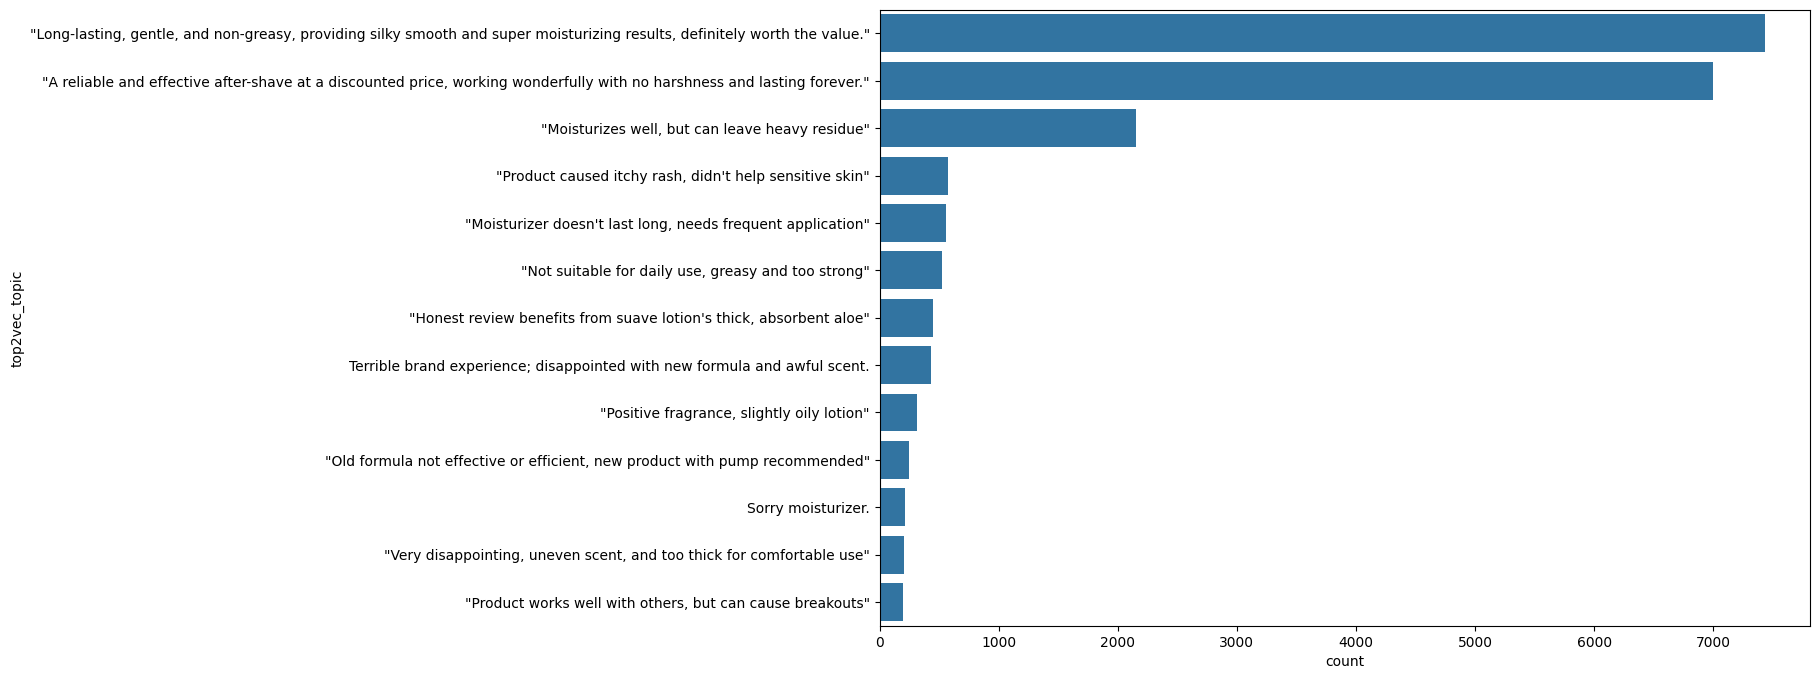

In [31]:
# bar chart of distribution of topics
plt.figure(figsize=(12, 8))
sns.countplot(y='top2vec_topic', data=new_df, order=new_df['top2vec_topic'].value_counts().index)


In [32]:
# group topics by each star rating
new_df.groupby('star_rating')['top2vec_topic'].value_counts()

star_rating  top2vec_topic                                                                                                             
1.0          "Product caused itchy rash, didn't help sensitive skin"                                                                        571
             "Not suitable for daily use, greasy and too strong"                                                                            527
             Terrible brand experience; disappointed with new formula and awful scent.                                                      427
2.0          "Old formula not effective or efficient, new product with pump recommended"                                                    244
             Sorry moisturizer.                                                                                                             216
             "Very disappointing, uneven scent, and too thick for comfortable use"                                                          206


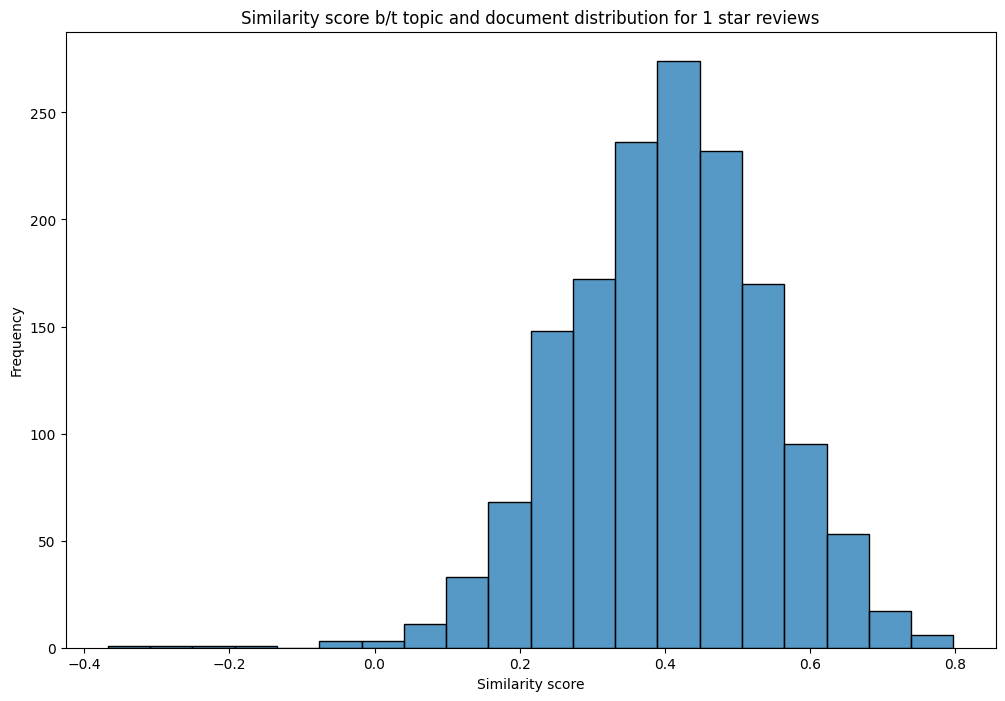

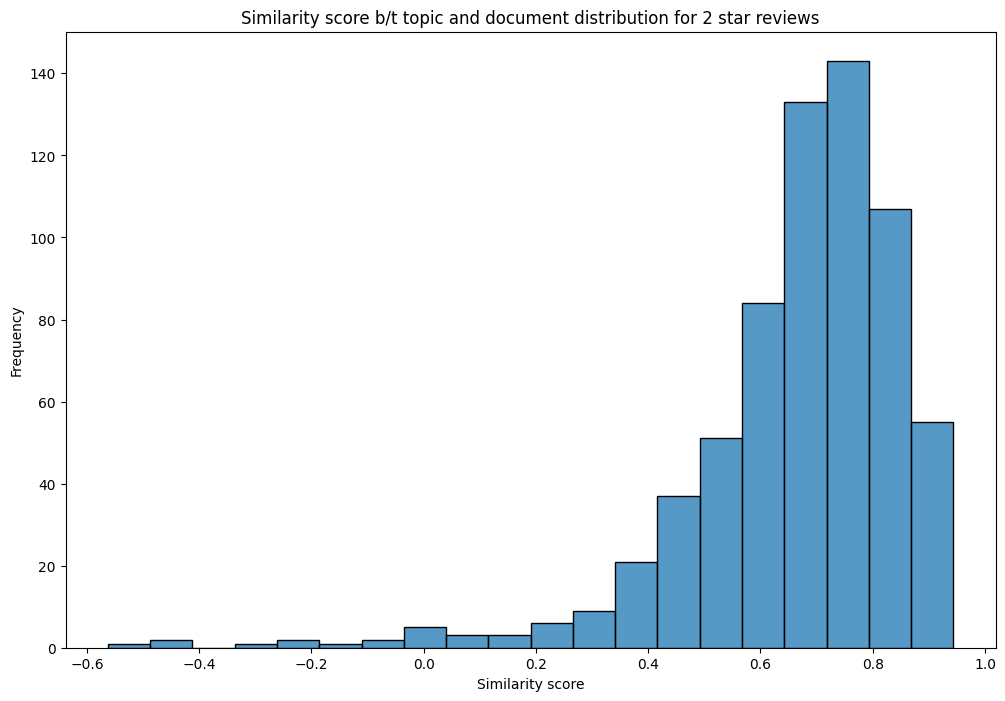

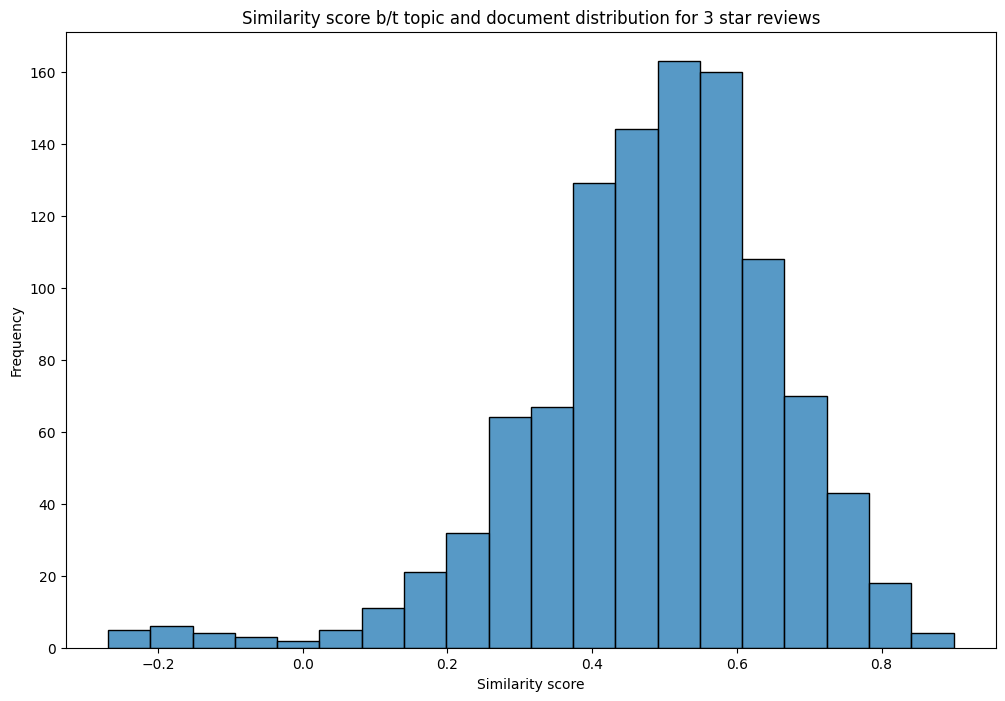

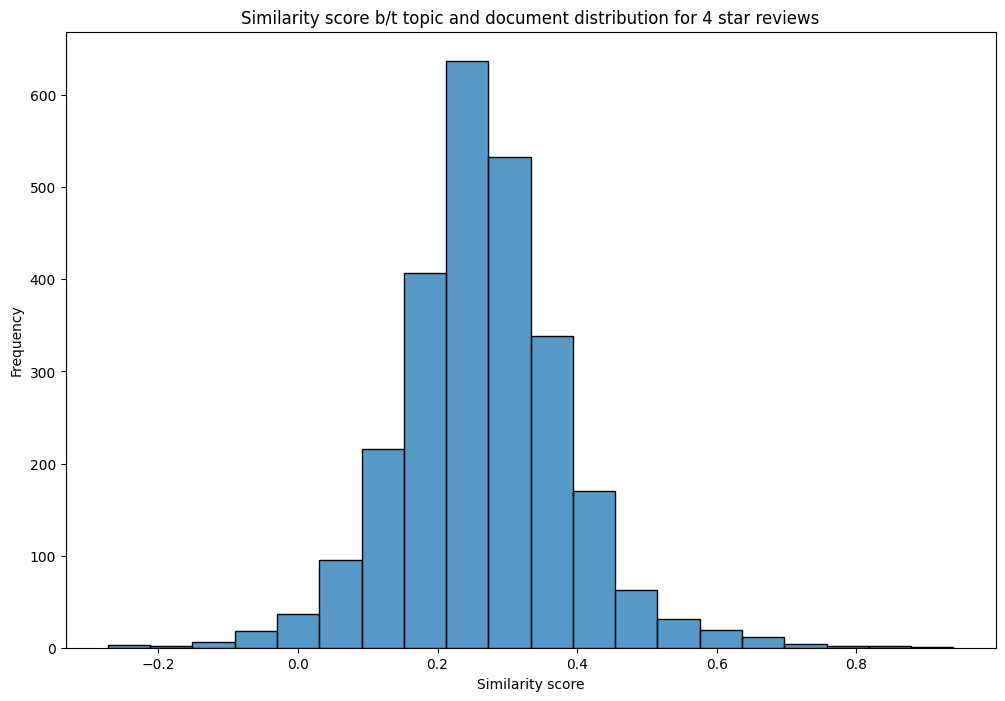

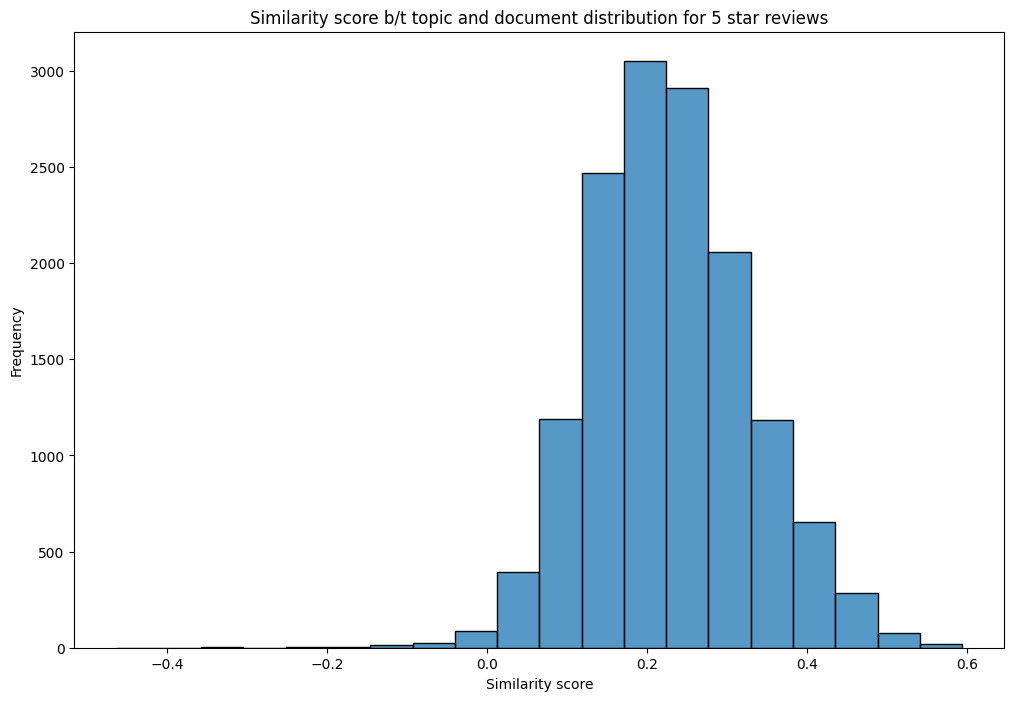

{1: 0.40270308, 2: 0.66285574, 3: 0.48556042, 4: 0.26502305, 5: 0.22912239}

In [33]:
# Average similarity score for each topic

average_similarity_scores = {}
for i in range(len(top2vec_models)):
    topic_nums, topic_score, topic_words, word_scores = top2vec_models[i].get_documents_topics(doc_ids=top2vec_models[i].document_ids, reduced=topic_reduction[i])
    # topic_score contains the semantic similarity score for each document to each topic
    average_similarity_scores[i+1] = np.mean(topic_score, axis=0)
    # plot the topic score distribution
    plt.figure(figsize=(12, 8))
    sns.histplot(topic_score, bins=20)
    plt.title(f"Similarity score b/t topic and document distribution for {i+1} star reviews")
    plt.xlabel("Similarity score")
    plt.ylabel("Frequency")
    plt.show()

average_similarity_scores

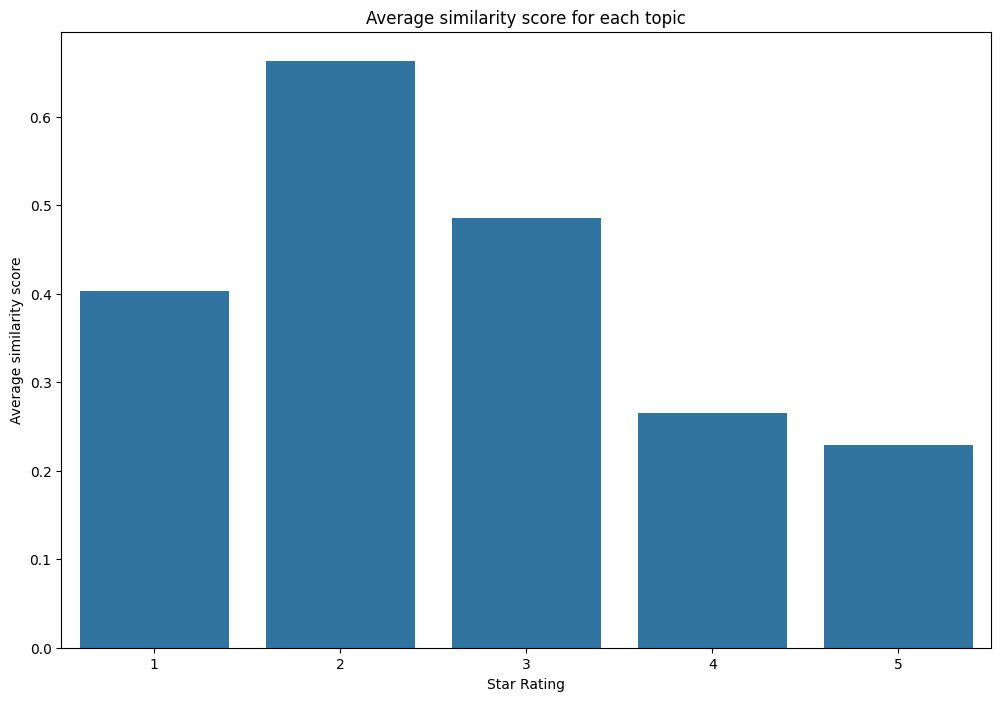

In [34]:
# PLot Average similarity score for each topic bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=list(average_similarity_scores.keys()), y=list(average_similarity_scores.values()))
plt.title("Average similarity score for each topic")
plt.xlabel("Star Rating")
plt.ylabel("Average similarity score")
plt.show()

## OLD CODE (IGNORE)

In [ ]:
refined_topics = []
for topic_words, word_scores, topic_nums in get_topics_output:
    refined_topics.append(process_input(top_words, rating))

In [20]:
topic_words, word_scores, topic_nums = top2vec.get_topics(number_of_topics)

In [21]:
for i in range(5):
    print(f"Topic {i}: {topic_words[i]}")

Topic 0: ['old formula' 'new formula' 'please change' 'please bring' 'bring back'
 'yr old' 'old school' 'old lady' 'new formulation' 'please please'
 'year old' 'original formula' 'change' 'they change' 'formula' 'old'
 'old version' 'new' 'please' 'original' 'bring' 'new version' 'back'
 'please consider' 'sad' 'loyal customer' 'customer service' 'lavender'
 'understand why' 'original lip' 'disappointed' 'aveeno stress' 'customer'
 'stress' 'awful' 'stress relieve' 'wrong with' 'come back' 'switch back'
 'go wrong' 'many year' 'just sit' 'why' 'many different' 'thats why'
 'nothing wrong' 'stress relief' 'find something' 'no longer'
 'extremely disappointed']
Topic 1: ['pump action' 'handy pump' 'broken pump' 'open' 'pink bottle' 'get ta'
 'pump' 'get dress' 'figure out' 'container' 'green top' 'large container'
 'top tier' 'break out' 'pump dispenser' 'seal' 'bottle' 'knock off'
 'squeeze' 'lid' 'difficult' 'small size' 'item arrive' 'low price'
 'squeeze tube' 'cap' 'small tube' 'c

Topic reduction form 216 to 15

In [22]:
top2vec.hierarchical_topic_reduction(15)

[[59, 0, 15, 175, 1],
 [169,
  117,
  64,
  183,
  146,
  21,
  104,
  27,
  8,
  122,
  103,
  208,
  166,
  147,
  156,
  17,
  212,
  163,
  100,
  87,
  215,
  132,
  196,
  209,
  118,
  194,
  40,
  69,
  159,
  86,
  152,
  141,
  110,
  112,
  205,
  162],
 [22, 140, 74, 89, 7, 150, 63, 144, 32, 6, 129, 10, 119, 123, 33, 148, 16],
 [185,
  71,
  192,
  176,
  96,
  38,
  170,
  121,
  72,
  49,
  153,
  78,
  124,
  130,
  70,
  26,
  23,
  126,
  65],
 [60, 106, 52, 142, 84, 55, 13, 111, 18, 133, 81, 76, 5],
 [186, 57, 2, 155, 137, 34, 53, 161, 92, 3],
 [41,
  211,
  62,
  164,
  114,
  180,
  11,
  113,
  90,
  198,
  160,
  88,
  203,
  131,
  200,
  188,
  95,
  93,
  190,
  99],
 [9, 12, 42, 172, 67, 135, 19, 85, 14],
 [182, 66, 168, 174, 206, 56, 136, 214, 116, 139, 167, 58],
 [46, 79, 193, 171, 202, 77, 83, 50, 179, 51, 45, 31],
 [201, 145, 44, 94, 189, 207, 98, 97, 210, 125, 24, 36, 29],
 [107, 82, 204, 28, 149, 158, 199, 143, 91, 138, 191, 197, 177],
 [181, 4, 25, 127,

In [23]:
red_topic_words, red_word_scores, red_topic_nums = top2vec.get_topics(15, reduced=True)

In [24]:
red_topic_words

array([['new formula', 'old formula', 'please change',
        'original formula', 'please bring', 'please please',
        'they change', 'change', 'new formulation', 'understand why',
        'original', 'yr old', 'old lady', 'old school', 'bring back',
        'find something', 'dont know', 'just drink', 'original lip',
        'year old', 'dont understand', 'pink bottle', 'still damp',
        'figure out', 'unless they', 'old version', 'cap', 'old',
        'loyal customer', 'reason why', 'come back', 'please',
        'wrong with', 'bad batch', 'order', 'thats why', 'go wrong',
        'positive review', 'customer service', 'write review', 'open',
        'what happen', 'bring', 'new', 'again unless', 'please consider',
        'many different', 'get dress', 'nothing wrong', 'get ta'],
       ['tattoo artist', 'long lasting', 'work wonder',
        'moisturizing property', 'doesnt irritate',
        'definitely recommend', 'feeling incredibly', 'long term',
        'absolute favo

In [25]:
refined_topics = []
for topic_words in red_topic_words:
  refined_topics.append(refine_topic(client, model, topic_words))

In [26]:
refined_topics

['"Reviving an old formula with a fresh approach to meet loyal customer needs."',
 '"Long-lasting moisturizing tattoo care for winter seasons provides great value."',
 '"Unlocking deep hydration and natural ingredients for a satisfied skincare routine."',
 '"Indulgent skincare with long-lasting hydration in a small, affordable package, surprisingly effective."',
 '"Natural relief from eczema flare-ups and dry skin with gentle bodily care products."',
 '"Transforming skin texture with Vaseline\'s intensive moisturizer"',
 '" Gentle yet effective moisturizing experiences for all skin types"',
 'Here is a 12-word topic phrase: "Deep hydration and anti-aging benefits in a fast-absorbing moisturizer for sensitive skin."',
 'Here is a 12-word topic phrase that captures the content and sentiment of the given words:\n\n"Gentle, long-lasting moisturizers for dry skin, recommended by dermatologists and families alike."',
 'Here is a topic phrase that captures the content and sentiment of the 50 

In [33]:
topic_nums, topic_score, topic_words, word_scores = top2vec.get_documents_topics(doc_ids=top2vec.document_ids, reduced=True)

In [34]:
clorox_df['topic_number'] = topic_nums

C:\Users\14015\AppData\Local\Temp\ipykernel_13688\2863586292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clorox_df['topic_number'] = topic_nums


In [35]:
clorox_df.reset_index(drop=True, inplace=True)

In [36]:
# based on the topic num, assign the actual topic
clorox_df['top2vec_topic'] = clorox_df['topic_number'].apply(lambda x: refined_topics[x])

C:\Users\14015\AppData\Local\Temp\ipykernel_13688\637770675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clorox_df['top2vec_topic'] = clorox_df['topic_number'].apply(lambda x: refined_topics[x])


In [37]:
clorox_df.head()

,brand,product_title,proxy_date,retailer,category,subcategory,review_text,star_rating,topic,brand_type,topic_number,top2vec_topic
0,Clorox,Clorox Clean-Up All Purpose Cleaner with Bleac...,2024-07-01,Costco,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,It does the work. That is enough for me.,5.0,Finding the Perfect Product,Clorox,7,"""Effective spray bottles never disappoint and ..."
1,Clorox,Clorox Clean-Up All Purpose Cleaner with Bleac...,2024-07-01,Costco,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,I use it in the restrooms and in the kitchen. ...,5.0,Disinfectant spray recommendations and reviews...,Clorox,4,"""Effective and Convenient Disinfectant for Mul..."
2,CVS Total Home,"Total Home Cleaner With Bleach, 32 OZ",2024-07-01,CVS,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,"I used this in my shower that had pink mold, a...",5.0,Effective products for mold and mildew removal...,Competitor,6,"""Cleaning shower and bathtub without scrubbing"""
3,Clorox,Clorox® Clean-Up® Cleaner + Bleach1 Value Pack...,2024-07-01,Amazon,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,I appreciate the value you get with this 3-pac...,5.0,Disinfectant spray recommendations and reviews...,Clorox,3,"""Powerful toilet bowl cleaner kills bacteria, ..."
4,Clorox,Clorox Clean-Up All Purpose Cleaner with Bleac...,2024-07-01,Target,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,Stayed at a beach condo for several months las...,5.0,Bathroom cleaning solutions,Clorox,7,"""Effective spray bottles never disappoint and ..."


In [39]:
# get the number of reviews per topic
clorox_df['top2vec_topic'].value_counts()

top2vec_topic
"Walmart bottle purchase experience plagued with leaking issues and satisfaction concerns"            540
"Deep Cleaning Power for a Fresh and Germ-Free Home"                                                  433
"All-purpose cleaning solution for nonporous surfaces with fresh scent and affordable price."         379
"Powerful toilet bowl cleaner kills bacteria, viruses, and leaves a fresh scent."                     372
"Effective and Convenient Disinfectant for Multiple Surfaces and Rooms"                               369
"Deep cleaning removes tough stains, keeps surfaces germ-free and job done"                           369
"Cleaning shower and bathtub without scrubbing"                                                       341
"Effective spray bottles never disappoint and solve various problems on hand."                        328
"Effective Bathroom Disinfectant for Long-Lasting Fresh Scent and Cleanliness"                        300
"Germ-free home cleaning solutio

In [40]:
# save the clorox df to a csv
clorox_df.to_csv("top2vec_clorox_topics.csv")